Email spam Detection with Machine Learning

Accuracy :  0.97847533632287
classification Report                precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Prediction:  ham


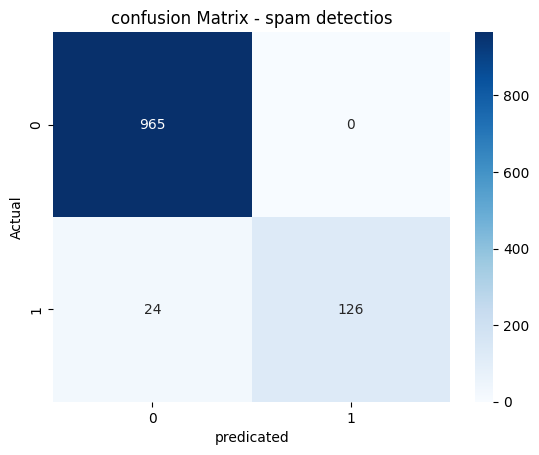

In [1]:
# loading important Libraries
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Data and clean the data 
df=pd.read_csv(r"C:\Users\jsuya\Documents\Email spam Detection with Machine Learning\spam.csv",encoding='latin1')
df.dropna(axis=1, inplace=True)
df.columns = ['label', 'message']

# Enoding the label data
le=LabelEncoder()
df['label_Encoded']=le.fit_transform(df['label'])

# split dataset into training and testing data sets 

x=df['message']
y=df['label_Encoded']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

# Feature text extraction using TF-IDF (trem frequency-inverse document frequancy)
tfidf=TfidfVectorizer(stop_words='english',max_features=3000)
x_train_tfidf=tfidf.fit_transform(x_train)
x_test_tfidf=tfidf.transform(x_test)

#next step is the model Buildings and & evaluation
model=MultinomialNB()
model.fit(x_train_tfidf,y_train)

# predicting the test data 
y_pred=model.predict(x_test_tfidf)

# evaluate the model
print("Accuracy : ",accuracy_score(y_test,y_pred))
print("classification Report ", classification_report(y_test,y_pred))


# Real-time testing
spam = input("Enter the spam detection message for real-time testing: ")

# Convert to TF-IDF features
spam_tfidf = tfidf.transform([spam])

# Make prediction
y_01 = model.predict(spam_tfidf)

# Convert numeric label back to text (ham/spam)
label_real_time = le.inverse_transform(y_01)

print("Prediction: ", label_real_time[0])


# confusion matrix 
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True ,fmt='d', cmap='Blues')
plt.xlabel('predicated')
plt.ylabel('Actual')
plt.title('confusion Matrix - spam detectios')
plt.show()
 